<div align="center">
<img src="../../../nisar_leno_biomass_files/NISAR_Mission_Logo.png" alt="key.png">  
</div>

# NASA ISRO Synthetic Aperture Radar Mission
<br>

## Algorithm Theoretical Basis Document and Jupyter Notebook for NISAR Biomass Retrieval
<br>

### Authors: 
> Naveen Ramachandran, KC Cushman, Alex Christensen, & Sassan Saatchi <br>
> Carbon Cycle and Ecosystems <br>
> Jet Propulsion Laboratory <br>
> California Institute of Technology <br>
> Date: 2025-07-18 <br>

### Summary
> This notebook describes the algorithm theoretical basis document (ATBD) for retrieving forest aboveground biomass (AGB) from a NISAR simulated time-series data stacks. The algorithm is designed to meet the Level 3 Science requirements for generating AGB product annually. This notebook constitutes a combination of formulating the theoretical basis for the NISAR Forest Biomass algorithm that is based on semi-empirical model and an implementation of the algorithm in executable python code. 

> A test data set accompanies the notebook that is available from NASA's Alaska Satellite Facility (ASF) and EarthExplorer and referenced in this notebook. Also accomanying the notebook is a python code library module (`atbd_biomass.py`) that is imported into this notebook in order for the example of the algorithm to execute within the notebook.

> In this notebook, we will walk through the various steps involved for estimation of NISAR L3 AGB product from NISAR simulated UAVSAR data. To illustrate the usage of NISAR AGB Model, we will use a NISAR simulated ALOS2 datasets acquired during NISAR Calibration/Validation phase.

> This ATBD notebook consists of following tasks:- 
> 1. **Data Downloading and Analysis** : This step performs data downloading and estimation of image statistics in HH and HV Polarization.
> 2. **Create Forest/Non-Forest Mask** : This steo generates FNF mask the SAR scene.
> 3. **Loading Calibrated Model & initial AGB Estimation** : This step loads the calibration parameters of NISAR biomass algorithm and estimates initial AGB values. 
> 4. **L3 Biomass Product Generation** : This str[ produces L3 Biomass Map over the entire sites.

> **The NISAR requirement for BIOMASS product is** *to measure above ground woody vegetation biomass annually at the hectare scale (1 ha) to an RMS accuracy of 20 Mg/ha for 80% of areas of biomass less than 100 Mg/ha.*

<a id="TOC"></a>
## Table of Contents
1. [Context on Forest Biomass and NISAR Time series](#section-1)
2. [Canopy Model for Radar Backscattering](#SEC_2) <br>
    2.1. [Basic Assumptions](#SEC_21) <br>
    2.2. [Further Simplifications](#SEC_22) <br>
    2.3. [Final Parameters for Retrieval Algorithm](#SEC_23) <br>
3. [Implementation of NISAR BIOMASS Algorithm](#SEC_3)
4. [Example of NISAR BIOMASS Algorithm Calibration/Validation](#SEC_4) <br>
    4.1. [Execute Notebook 0: Data Downloading and Analysis](#SEC_41) <br>
    4.2. [Execute Notebook 1: Create Calibration / Validation Products](#SEC_42) <br>
    4.3. [Execute Notebook 2: NISAR Model Calibration & Validation](#SEC_43) <br>
    4.4. [Execute Notebook 3: L3 Biomass Product Generation](#SEC_44) <br>
    4.5. [Execute Notebook 4: Uploading L3 Biomass products to Cal./Val and/or S3 Database](#SEC_45) <br>
5. [References](#SEC_5) <br>

<a id="section-1"></a>
## 1. Context on Forest Biomass and NISAR Time series

> Forest aboveground biomass (AGB) is a underlying parameter for predicting the spatial distribution of carbon in the terrestrial ecosystem. Also, it is vital from an economic (assits food, timber, and energy industry), disaster (forest fire, etc.), soil (soil errosion, landslide, etc.), water (flooding, water quality, etc.) biodoversity management (Foley et al. 2005; Chazdon 2008). However, the current knowledge of the distribution and magnitude of terrestrial biomass is based almost entirely on ground measurements over an extremely small, and possibly biased sample, with almost no measurements in the southern hemisphere and equatorial regions (Schimel et al., 2015). Forest AGB is directly related to the structural attributes of the forest. Synthetic Aperture Radar (SAR) backscatter measurements are sensitive to forest strctural information. Hence it can be correlated to AGB. However, the SAR backscatter sensitivity to AGB varies depending on the wavelength and geometry of the radar measurements, and is influenced by the surface topography, structure of vegetation, and environmental conditions such as soil moisture and vegetation phenology or moisture.

> For the NISAR mission, the focus was on AGB values between 0- 100 Mg/ha, as the sensitivity of L-band backscatter measurements to AGB saturates around 100 Mg/ha (Yu Lin 2016), which covers 50% of the global forests and the entire area of other woody vegetation (FRA, 2010). Also, with wide swath (240 km), high resolution (~15m), 12-day repeat orbit cycle, it allow retrieval of AGB at high spatial resolution over global scale temporally, allowing us to understand the dynamics of forest ecosystem. 




<a id="SEC_2"></a>
## 2. Canopy Model for Radar Backscattering


>The physical based data-fitted model (Saatchi and McDonald, 1997) describes scattering mechanisms of the forest with three  components **(Fig. 1)**, namely direct **D** , Interactive **I** , i.e., direct-reflect, and ground **G** components.  

>The **D** component consists of the scattering from trunks, branches, and leaves directly back to the sensor.  The **I** terms, also known as "double bounce" term, is the scattering that includes interaction between trees and ground.  This includes the trunk-ground, crown-ground scattering.  The **G** component is the scattering directly back from ground attenuated by the forest canopy.

<div align="center">
<img src="../../../nisar_leno_biomass_files/fig1.png" alt="key.png">  
</div>

<h3 style="text-align:center;">
  <strong>Fig 1:</strong> Scattering mechanisms of forest scattering model
</h3>

> The model can be written in the form of the following equation,

$$
\begin{align}
\sigma_0(p,s,t) & = A_{p,t} W_s^{\alpha_p} (1 - \exp(-B_{p,t} W_s^{\beta_p})) \quad\quad\quad & [D: Volume] \\
               & + C_{p,t} W_s^{\gamma_p} \Gamma_{p,t} \exp(-B_{p,t} W_s^{\beta_p})  \quad\quad\quad & [I: Volume-Surface] \\
               & + S_{p,t} \exp(-B_{p,t} W_s^{\beta_p})  \quad\quad\quad & [G: Surface]
\end{align}
$$

> where the subscripts $p, s, t$ represents the variations over $polarization, space, time$.

> [back to TOC](#TOC)

<a id="SEC_21"></a>
> ### 2.1. Basic Assumptions
>The simplified assumptions here include: <br>
>1. Parameters $A_{p,t}, B_{p,t}, C_{p,t}$ change over time and different polarizations, but vary little spatially within a local window.
>2. Parameters $\alpha_{p}, \beta_{p}, \gamma_{p}$ change with different polarizations, but vary little temporally, or spatially within a local window. 
>3. Parameters $\Gamma_{p,t}, S_{p,t}$, related to both surface roughness and dielectric properties, change over time and different polarizations,but vary little spatially within a local window.

> [back to TOC](#TOC)

<a id="SEC_22"></a>
> ### 2.2. Further Simplifications
> We rewrite the original equation as

> $$
\begin{align}
\sigma_0(p,s,t) & = A_{p,t} W_s^{\alpha_p} (1 - \exp(-B_{p,t} W_s^{\beta_p})) \quad\quad\quad & [D] \\
               & + C_{p,t} W_s^{\gamma_p} \Gamma_{p,t} \exp(-B_{p,t} W_s^{\beta_p})  \quad\quad\quad & [I] \\
               & + S_{p,t} \exp(-B_{p,t} W_s^{\beta_p})  \quad\quad\quad & [G] \\
\Rightarrow \quad\quad\quad \quad\quad\quad  & \\
\sigma_0(p,s,t) & = A_{p,t} W_s^{\alpha_p} (1 - \exp(-B_{p,t} W_s)) \quad\quad\quad & [D] \\
               & + C'_{p,t} S_{t} W_s^{\gamma_p} \exp(-B_{p,t} W_s)  \quad\quad\quad & [I] \\
               & + D_{p} S_{t} \exp(-B_{p,t} W_s) \quad\quad\quad & [G]
\end{align}
$$

> where we have 

>**Assumption 1:**

$$
\begin{align}
\beta_p & = 1
\end{align}
$$

>This assumption is consistent with the estimation of forward model simulations.

>**Assumption 2:**

>$S$ term (backscattering crosssection from soil rough surface, no dependency on vegetation) is separated into polarization-dependent term and time-dependent term,

$$
\begin{align}
S_{p,t} & = D_{p} S_{t}
\end{align}
$$


>**Assumption 3:**

>$C\Gamma$ term (reflectivity of the soil rough surface, and no dependency on vegetation) is rewritten as the new constant $C'$ with time-dependent $S_t$,

$$
\begin{align}
C_{p,t} \Gamma_{p,t} & = C_{p,t} K_{p} S_{t} \\
                     & = C'_{p,t} S_{t} 
\end{align}
$$
> [back to TOC](#TOC)


<a id="SEC_23"></a>
> ### 2.3. Final Parameters for Retrieval Algorithm

>Based on the above simplications, we have the following list of unknown parameters to solve:

$$ A_{p,t}, B_{p,t}, C'_{p,t}, D_{p}, \alpha_p, \gamma_p, S_t, W_s $$

>For possible solutions, we need to satisfy the following condition,

$$ 3pt + 3p + t + s < pts $$ 

>For example, a 2-polarization system of 3x3-window retrieval needs at least 2 multi-temporal observations to satisfy the condition above.

> [back to TOC](#TOC)



<a id="SEC_3"></a>
## 3. Implementation of NISAR BIOMASS Algorithm

<div align="center">
<img src="../../../nisar_leno_biomass_files/Approach.png" alt="key.png">  
</div>

<h3 style="text-align:center;">
  <strong>Fig 2:</strong> Framework for NISAR calibration/validation Approach.
</h3>

    
**Fig. 2** outlines the framework for NISAR calibration/validation approach. The NISAR biomass algorithm is based on time series observation using NISAR L-band calibrated backscatter measurements at HH and HV polarization. The datasets used in this study consists NISAR or NISAR Simulated time-series datasets , LiDAR AGB maps and Land Use/Land Cover (LULC) maps. The framework, downloads the GCOV datasets, performs resampling of datasets to master geometry to generate a stack of time-series SAR imageries at 100 m resoltuion. Also, the LiDAR AGB and LULC maps are resampled to align with master geometry. Once the data stack is generated, the data cleaning is performed to remove outlier from the SAR datastack and LiDAR AGB Map (resmapling, modeling error, forest change). Once pre-processing is performd the notebooks calculates initial model parameters of NISAR semi-emperical model (canopy model) using LiDAR Map and stack of time-series SAR imageries. An initial AGB map is generated using quadratic model for entire scene, which is used as an initial AGB value for AGB estimation over entire scene. Then the inital model parameters and AGB values along with the their bound values was used to retrived the AGB map for entire scene at pixel level. The accuracy of the map over calibration/ validation area was estimated and a valdiation report is generated. Finally, the L3 AGB map along with the associate auxially files are exported into cal/val database.

</p>


The NISAR algorithm will make use of high-resolution and time series backscatter observations at dual-polarizations (HH and HV) to estimate AGB by compensating for the effects of environmental changes (soil and vegetation moisture and phenology) and structure (vegetation and surface topography).

<a id="SEC_4"></a>
## [4. Example of NISAR BIOMASS Algorithm Calibration/Validation](#SEC_4)

### 4. 1. Data Downloading and Analysis

### Overview of Tasks Performed
> 1. **Data Directory Setup** : A structured directory layout is established to organize the data into raw, processed, and output directories. This ensures that the workflow remains clean and modular as we download, preprocess, and store the data.
> 2. **Data Streaming** : We implement functionality to stream the NISAR GCOV products from ASF or EARTHACCESS and save geotiff into the local directory. This step ensures that the data is readily available for further processing.
> 3. **Image Statistics Computation** : In this section, we calculate basic image statistics (mean, standard deviation, min, max pixel values) to gain insights into the image data. These statistics can help identify potential issues with the images (such as inconsistent lighting or color distribution) and guide the selection of data.

### Project Setup

#### Load the required pre-defined packages.

In [1]:
import io
import os
import sys
import h5py
import s3fs
import getpass
import requests
import rasterio
import subprocess
import earthaccess
import asf_search
import glob
import configparser

import pandas as pd
import numpy as np
import geopandas as gpd
import asf_search as asf
import matplotlib.pyplot as plt
import matplotlib as mpl
from osgeo import gdal
from pathlib import Path
from datetime import datetime
from shapely.geometry import box
from matplotlib.ticker import FuncFormatter

## Calibration Information

In [2]:
SITE = 'TestSite'

##### Change the below 3 cells to code and run if you are independently running the notebooks

In [3]:
#### THE MAIN DIRECTORY IN WHICH THE DATABASE FOR PROCESSING WILL BE SETUP 
CUR_DIR =  Path(os.getcwd())  # GET THE CURRENT DIRECTORY

In [4]:
#### 1. THE MAIN DIRECTORY IN WHICH THE DATABASE FOR PROCESSING WILL BE SETUP 
MAIN_DIR = Path(CUR_DIR).parents[2]  # CHANGE THE PATH MAIN DIRECTORY

#### Load the required custom packages.

In [5]:
#### 3. PATH TO THE DIRECTORY WHERE THE CUSTOM MODULES ARE STORED 
SCRIPT_DIR =  MAIN_DIR / Path('algorithm/bin/')

In [6]:
#### INSERT THE PATH OF SCRIPT DIRECTORY TO SYSTEM PATH TO LOAD THE CUSTOM MODULES AND ROTUINES  
sys.path.insert(1, str(SCRIPT_DIR))

#### LOAD THE CUSTOM MODULES AND ROTUINES
import functions as fn
import model_radar as mr

### SETUP THE DATA DIRECTORY STRUCTURE 

##### DATA DIRECTORY 

In [7]:
DATA_DIR = MAIN_DIR / Path('data_repo/data/nisar_simulated/' + SITE + '/')
os.makedirs(DATA_DIR, exist_ok='True') # CREATES DATA DIRECTORY IF NOT EXISTING 

##### PROCESSING DIRECTORIES 

In [8]:
#### PROCESSING DIRECTORY 
PROCESS_DIR = MAIN_DIR / Path('data_repo/processing/nisar_simulated/' + SITE + '/')
os.makedirs(PROCESS_DIR, exist_ok='True') # CREATES Processing DIRECTORY IF NOT EXISTING 

In [9]:
#### META DATA DIRECOTRY 
META_DIR = PROCESS_DIR / 'Metadata'
os.makedirs(META_DIR, exist_ok='True') # CREATES META DIRECTORY IF NOT EXISTING 

In [10]:
#### SAR GCOV TIMESERIES GEOTIFF 
GCOV_DIR = PROCESS_DIR / 'GCOV/'
os.makedirs(GCOV_DIR, exist_ok='True') # CREATES SAR TIMESERIES DIRECTORY IF NOT EXISTING  

In [11]:
#### RESAMPLED SAR TIMESERIES GEOTIFF 
GCOV_STACKS_DIR = PROCESS_DIR / 'GCOV_STACKS/'
os.makedirs(GCOV_STACKS_DIR, exist_ok='True') # CREATES RESAMPLED SAR TIMESERIES DIRECTORY IF NOT EXISTING 

In [12]:
#### RESAMPLED LULC MAPS
LULC_DIR = PROCESS_DIR / 'LULC'
os.makedirs(LULC_DIR, exist_ok='True') # CREATES RESAMPLED LULC DIRECTORY IF NOT EXISTING 

##### OUTPUT DIRECTORIES 

In [13]:
#### OUTPUT DIRECTORY 
OUTDIR_DIR = MAIN_DIR / Path('data_repo/output/nisar_simulated/' +  SITE + '/')
os.makedirs(OUTDIR_DIR, exist_ok='True')  # CREATES OUTPUT DIRECTORY IF NOT EXISTING 

### Data Streaming 
The NISAR GCOV Products can be downloaded from the  NASA's Alaska Satellite Facility (ASF) or EarthExplorer repositary.  

#### Query the Database for SAR dataset

In [14]:
ALL_GCOV_DATA_LINKS = ['https://s3.us-west-1.wasabisys.com/nisar-public-ebd/ATBD/ecosystems/disturbance/sites/leno/GCOV/simulated/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777.h5' ,
             'https://s3.us-west-1.wasabisys.com/nisar-public-ebd/ATBD/ecosystems/disturbance/sites/leno/GCOV/simulated/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777.h5' ,
             'https://s3.us-west-1.wasabisys.com/nisar-public-ebd/ATBD/ecosystems/disturbance/sites/leno/GCOV/simulated/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777.h5' , 
             'https://s3.us-west-1.wasabisys.com/nisar-public-ebd/ATBD/ecosystems/disturbance/sites/leno/GCOV/simulated/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777.h5' , 
             'https://s3.us-west-1.wasabisys.com/nisar-public-ebd/ATBD/ecosystems/disturbance/sites/leno/GCOV/simulated/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777.h5' ,
             'https://s3.us-west-1.wasabisys.com/nisar-public-ebd/ATBD/ecosystems/disturbance/sites/leno/GCOV/simulated/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777.h5'
            ]

In [19]:
ALL_GCOV_DATA = [os.path.basename(x) for x in ALL_GCOV_DATA_LINKS]

#### Stream and Convert the NISAR Simulated H5 Files to GEOTIFF

In [29]:
SAR_DATA_LIST = []
for image in ALL_GCOV_DATA_LINKS:
    response = requests.get(image, stream = True)
    data = io.BytesIO(response.content)
    F = h5py.File(data, "r") 
    FILE_ID = os.path.basename(image)
    A_GROUP_KEY = list(F.keys())[0]
    DS_X = F[A_GROUP_KEY]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
    DS_Y = F[A_GROUP_KEY]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
    DS_EPSG = F[A_GROUP_KEY]['LSAR']['GCOV']['grids']['frequencyA']['projection'][()]
    DS_HHHH = F[A_GROUP_KEY]['LSAR']['GCOV']['grids']['frequencyA']['HHHH'][()]  # returns as a numpy array
    DS_HVHV = F[A_GROUP_KEY]['LSAR']['GCOV']['grids']['frequencyA']['HVHV'][()]  # returns as a numpy array
    
    print('Raster bounds: ',min(DS_X),max(DS_X),min(DS_Y),max(DS_Y))
    print('X Size: ',DS_X.shape[0],' Y Size: ',DS_Y.shape[0])
    print('Resolution: ', DS_Y[0] - DS_Y[1],'m')
    print('')
    meta = {'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': None, 
            'width': DS_X.shape[0], 
            'height': DS_Y.shape[0], 
            'count': 1, 
            'crs': rasterio.CRS.from_epsg(DS_EPSG[()]), 
            'transform': rasterio.Affine(DS_X[1] - DS_X[0], 0.0, DS_X[0], 0.0, DS_Y[1] - DS_Y[0], DS_Y[0]), 
            'tiled': False, 
            'interleave': 'band'}

    with rasterio.open(GCOV_DIR / FILE_ID.replace('.h5', '_HHHH_power.tif'), 'w', **meta) as dst:
            dst.write(DS_HHHH,indexes=1)    
    with rasterio.open(GCOV_DIR / FILE_ID.replace('.h5', '_HVHV_power.tif'), 'w', **meta) as dst:
        dst.write(DS_HVHV,indexes=1)    
    SAR_DATA_LIST.append(GCOV_DIR / FILE_ID.replace('.h5', '_HVHV_power.tif'))
    SAR_DATA_LIST.append(GCOV_DIR / FILE_ID.replace('.h5',  '_HHHH_power.tif'))
    print(FILE_ID)

Raster bounds:  328110.0 424430.0 3495310.0 3577930.0
X Size:  4817  Y Size:  4132
Resolution:  20.0 m



NameError: name 'SAR_DATA_LIST' is not defined

#### Get the Dates of the NISAR Simulated Data

In [20]:
#### CREATE A METAFILE WITH LIST OF ALL PRODUCTS AND DATES AND SAVE
DATES = [fn.date_from_filename(filename) for filename in  ALL_GCOV_DATA_LINKS]  # GET THE DATE OF DATA ACQUISITION FOR EACH PRODUCT ID
DATES = sorted(DATES) # SORT THE DATES)

In [21]:
# SORT THE PRODUCT ID BASED ON DATES
ALL_GCOV_DATA = sorted(ALL_GCOV_DATA, key=fn.date_from_filename)
ALL_GCOV_DATA

['NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777.h5']

In [22]:
# CREATE A LIST WITH DATES AND PRODUCT ID
SAR_DATA_ID = []
for BAND_INDEX in range(len(ALL_GCOV_DATA_LINKS)):
    SAR_DATA_ID.append((DATES[BAND_INDEX], ALL_GCOV_DATA[BAND_INDEX]))

#### Save the List of NISAR Simulated Data to the CSV File 

In [23]:
# CONVERT THE CREATED LIST TO DATAFRAME WITH HEADER
SAR_DATA_ID = pd.DataFrame(data = SAR_DATA_ID, columns =['DATES', 'PRODUCT_ID']) 
# SAVE THE DATAFRAME TO META DIRECTORY 
SAR_DATA_ID.to_csv(META_DIR / Path(SITE + '_nisarsimulated_Data_List.csv'), index=False) 

In [24]:
# DISPLAY THE PRODUCT ID WITH DATES
pd.set_option('display.max_colwidth', None)
SAR_DATA_ID.style.set_properties(**{'text-align': 'center'})
display(SAR_DATA_ID) 

DATES  \
0  2021-08-06   
1  2021-08-20   
2  2021-09-03   
3  2021-09-17   
4  2021-10-01   
5  2021-10-15   

                                                                                       PRODUCT_ID  
0  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777.h5  
1  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777.h5  
2  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777.h5  
3  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777.h5  
4  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777.h5  
5  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777.h5

#### Create a reference file of 100 m X100 m resolution  
To create L3 product at 100 m resolution, the reference image is generated to resample all products to 100 m resolution.

In [25]:
# THE NISAR PRODUCTS ARE VALIDATED AT 1-ha (100 m X100 m) RESOLUTION
INPUT_FILE     = SAR_DATA_LIST[0] # PATH TO THE INPUT FILE FOR CREATING REFERENCE IMAGE
REFERENCE_FILE = GCOV_STACKS_DIR / Path(SITE + "_100m_REF.tif") # PATH OF THE CREATED REFERENCE IMAGE  

NameError: name 'SAR_DATA_LIST' is not defined

In [26]:
# CREATE A GDAL EXPRESSION TO RESAMPLE THE INPUT FILE BY AVERAGING OVER 100 m X100 m  
gdal_expression = f'gdal_translate -tr 100 100 -r average {INPUT_FILE} {REFERENCE_FILE}'

NameError: name 'INPUT_FILE' is not defined

In [27]:
# RUN THE GDAL EXPRESSSION THROUGH THE SHELL AND CAPTURE ITS OUTPUT
subprocess.check_output(gdal_expression, shell=True)

NameError: name 'gdal_expression' is not defined

#### Resample all RTC SAR images to reference image geometry

In [70]:
# RESAMPLE ALL RTC SAR DATA TO REFERENCE IMAGE AND STORE INTO 
SAR_RES_DATA_LIST = []
for IN_FILE in SAR_DATA_LIST:
    # RESAMPLED OUTPUT FILE NAME 
    OUT_FILE = GCOV_STACKS_DIR / os.path.basename(IN_FILE).replace(".tif", "_100m.tif")
    # RESAMPLED INPUT FILE TO REFERENCE GEOMETRY 
    fn.raster_clip(REFERENCE_FILE, IN_FILE, OUT_FILE, resampling_method="average")  
    # APPEND THE RESAMPLED FILE NAME
    SAR_RES_DATA_LIST.append(OUT_FILE) 
    

gdalwarp -s_srs "+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs" -t_srs "+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs" -te 328110.0 3495330.0 424410.0 3577930.0 -ts 963 826 -srcnodata nan -dstnodata nan -overwrite -multi -co COMPRESS=DEFLATE -co ZLEVEL=1 -co PREDICTOR=2 -co BIGTIFF=YES -r average -ot Float32 "/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777_HVHV_power.tif" "/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777_HVHV_power_100m.tif"
gdalwarp -s_srs "+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs" -t_srs "+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs" -te 328110.0 3495330.0 424410.0 3577930.0 -ts 963 826 -srcnodata nan -dstnodata nan -overwrite -multi -co COMPRESS=DEFLATE -co ZLEVEL=1 -co PREDICTOR=2 -co BIGTIFF=YES

#### Save the List of Resampled NISAR Simulated ALOS2 Data to the CSV File 

In [71]:
SAR_RES_DATA_ID = pd.DataFrame(data = SAR_RES_DATA_LIST, columns =['DATA_ID'])  # CONVERT THE RESAMPLED LIST TO DATAFRAME 
SAR_RES_DATA_ID.to_csv(META_DIR / Path(SITE + '_nisarsimulated_Band_List.csv'), index=False) # SAVE THE DATAFRAME TO META DIRECTORY 

In [72]:
pd.set_option('display.max_colwidth', None)
display(SAR_RES_DATA_ID) # DISPLAY THE BANDS 

DATA_ID
0   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777_HVHV_power_100m.tif
1   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777_HHHH_power_100m.tif
2   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777_HVHV_power_100m.tif
3   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777_HHHH_power_100m.tif
4   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777_HVHV_power_100m.tif
5   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777_HHHH_power_100m.tif
6   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777_HVHV_power_100m.tif
7   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777_HHHH_power_100m.tif
8   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777_HVHV_power_100m.tif
9   /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777_HHHH_power_100m.tif
10  /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777_HVHV_power_100m.tif
11  /home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777_HHHH_power_100m.tif

### Image Statistics Computation

In [73]:
#### CALCULATE IMAGE STATISTICS 
NUM_SCENES = int(len(SAR_RES_DATA_LIST)/2)
# INITIALIZE THE HH FILE LIST
HH_FILES = []  
# INITIALIZE THE HV FILE LIST
HV_FILES = []  
for NUM in range(NUM_SCENES):
    # HH data 
    HV_FILES.append(SAR_RES_DATA_LIST[NUM*2 + 0]) # APPEND THE HV FILES 
    # HV data 
    HH_FILES.append(SAR_RES_DATA_LIST[NUM*2 + 1]) # APPEND THE HH FILES

In [74]:
HH_FILES

[PosixPath('/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777_HHHH_power_100m.tif'),
 PosixPath('/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777_HHHH_power_100m.tif'),
 PosixPath('/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777_HHHH_power_100m.tif'),
 PosixPath('/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777_HHHH_power_100m.tif'),
 PosixPath('/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/GCOV_STACKS/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_2021100

### HV Statistics

In [75]:
##### CALCULATE HV IMAGE STATISTICS 
DF_HV = fn.image_statistics(HV_FILES, SITE, POL = 'HV') 
# WRITE THE DATAFRAME OF HV IMAGE STATISTICS TO CSV FILE 
DF_HV.to_csv(META_DIR / Path(SITE + "_HV_STATS.csv")) 
# DISPLAY THE HV STATISTICS
display(DF_HV)  

BAND  \
0    1   
1    2   
2    3   
3    4   
4    5   
5    6   

                                                                                     BAND_NAME  \
0  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777   
1  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777   
2  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777   
3  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777   
4  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777   
5  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777   

      MIN     MAX    MEAN  MEDIAN      SD  SKEWNESS  KURTOSIS  
0  0.0015  0.8523  0.0896  0.0952  0.0319   -0.5604    0.7240  
1  0.0017  0.9257  0.1021  0.1078  0.0339   -0.5827    0.9201  
2  0.0017  0.9552  0.0939  0.0997  0.0315   -0.6145    1.4369  
3  0.0018  0.8125  0.1041  0.1096  0.0338   -0.5949    0.6866  
4  0.0017  0.8909  0.0965  0.1022  0.0314   -0.6217    1.1622  
5  0.0015  0.8313  0.0863  0.0924  0.0308   -0.6327    0.8431

### HH Statistics

In [76]:
# CALCULATE HH IMAGE STATISTICS
DF_HH = fn.image_statistics(HH_FILES, SITE, POL = 'HH')   
# WRITE THE DATAFRAME OF HH IMAGE STATISTICS TO CSV FILE
DF_HH.to_csv(META_DIR / Path(SITE + "_HH_STATS.csv")) 
# DISPLAY THE HH STATISTICS
display(DF_HH) 

BAND  \
0    1   
1    2   
2    3   
3    4   
4    5   
5    6   

                                                                                     BAND_NAME  \
0  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777   
1  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777   
2  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777   
3  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777   
4  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777   
5  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777   

      MIN        MAX    MEAN  MEDIAN      SD  SKEWNESS    KURTOSIS  
0  0.0054  42.688099  0.3296  0.3265  0.1379   65.1217  18365.0834  
1  0.0059  44.370201  0.3661  0.3594  0.1523   62.4778  15084.4252  
2  0.0059  45.435799  0.3621  0.3439  0.1722   43.1974   9737.7713  
3  0.0065  45.914600  0.3791  0.3659  0.1620   57.4714  13487.6851  
4  0.0055  47.172100  0.3639  0.3490  0.1574   59.0215  16024.8275  
5  0.0057  44.240799  0.3344  0.3272  0.1489   55.9181  15429.0118

### SAR Time Series Visualization and Analysis

#### Plot NISAR Simulated ALOS2 HH and HV Polarization Images 

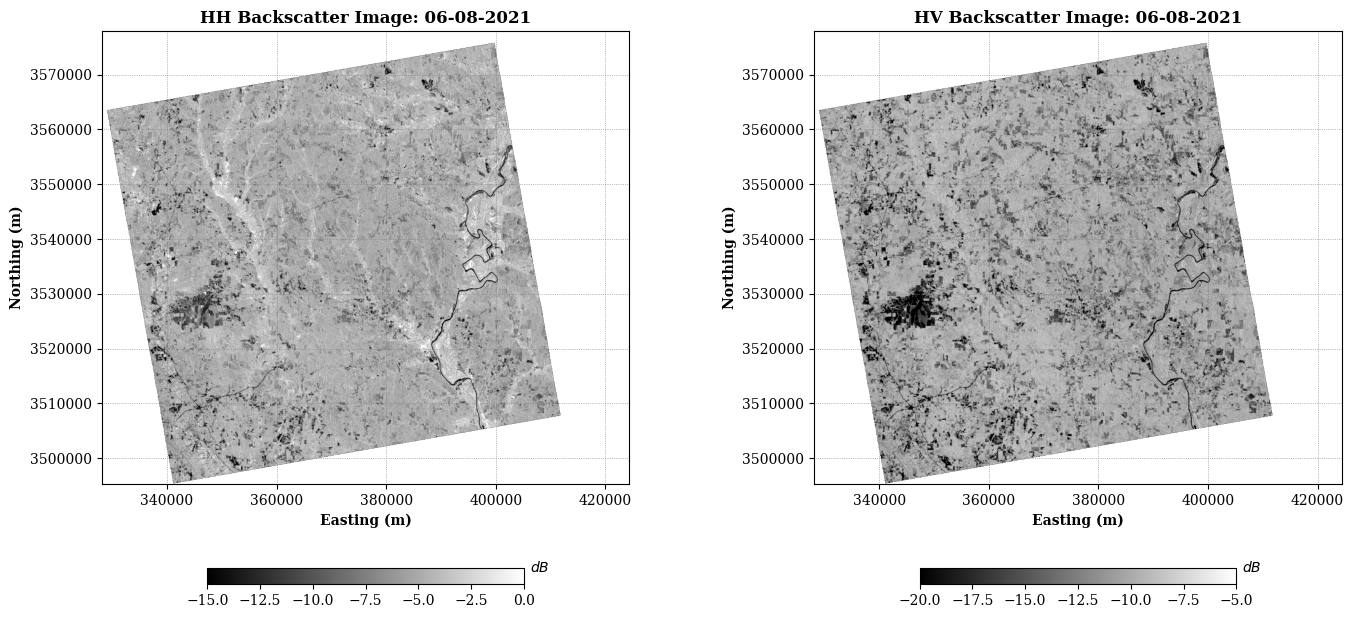

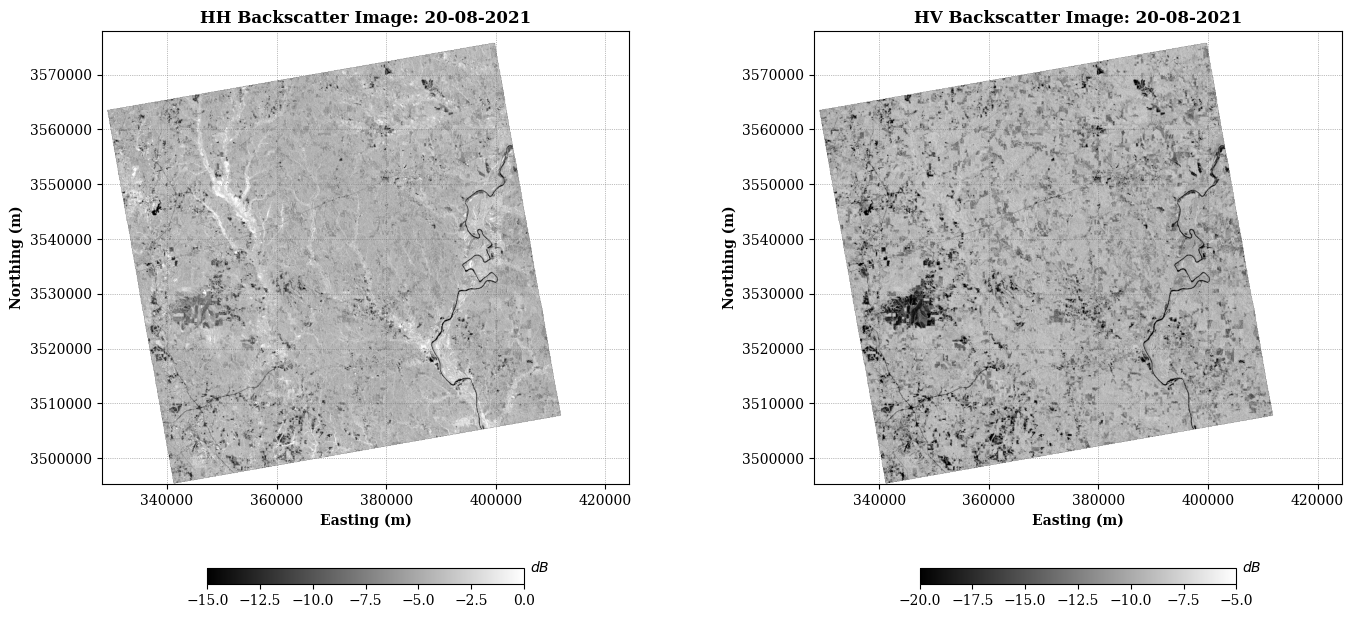

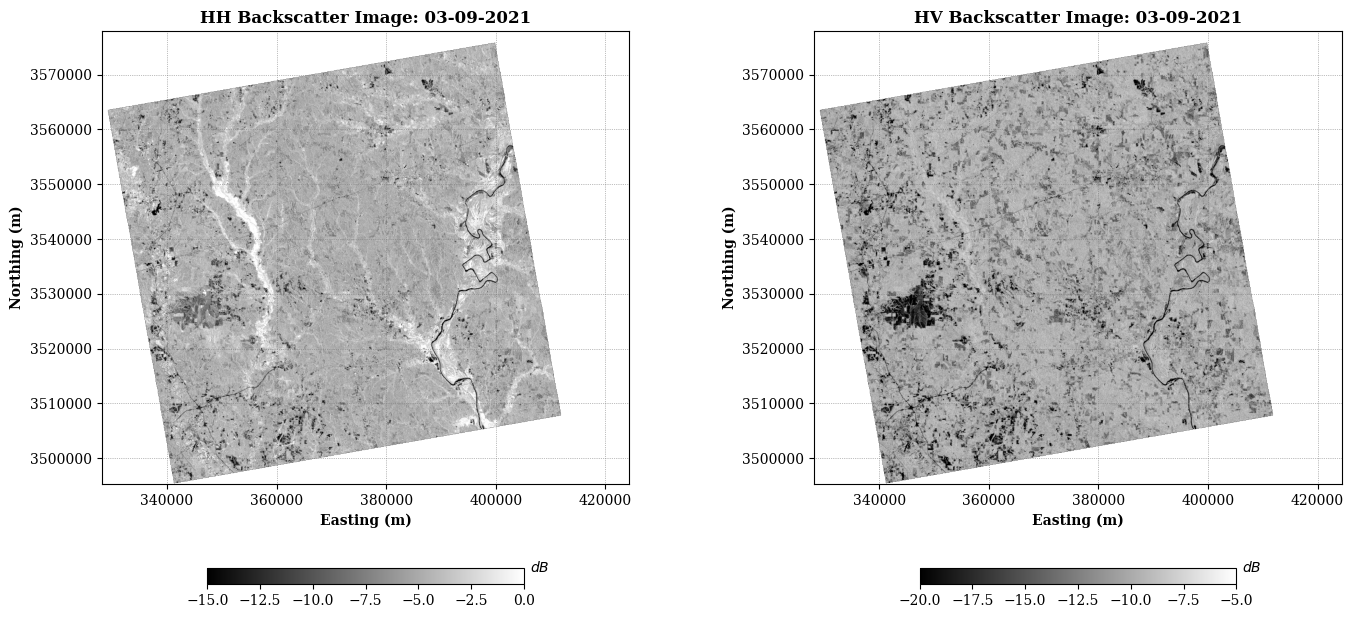

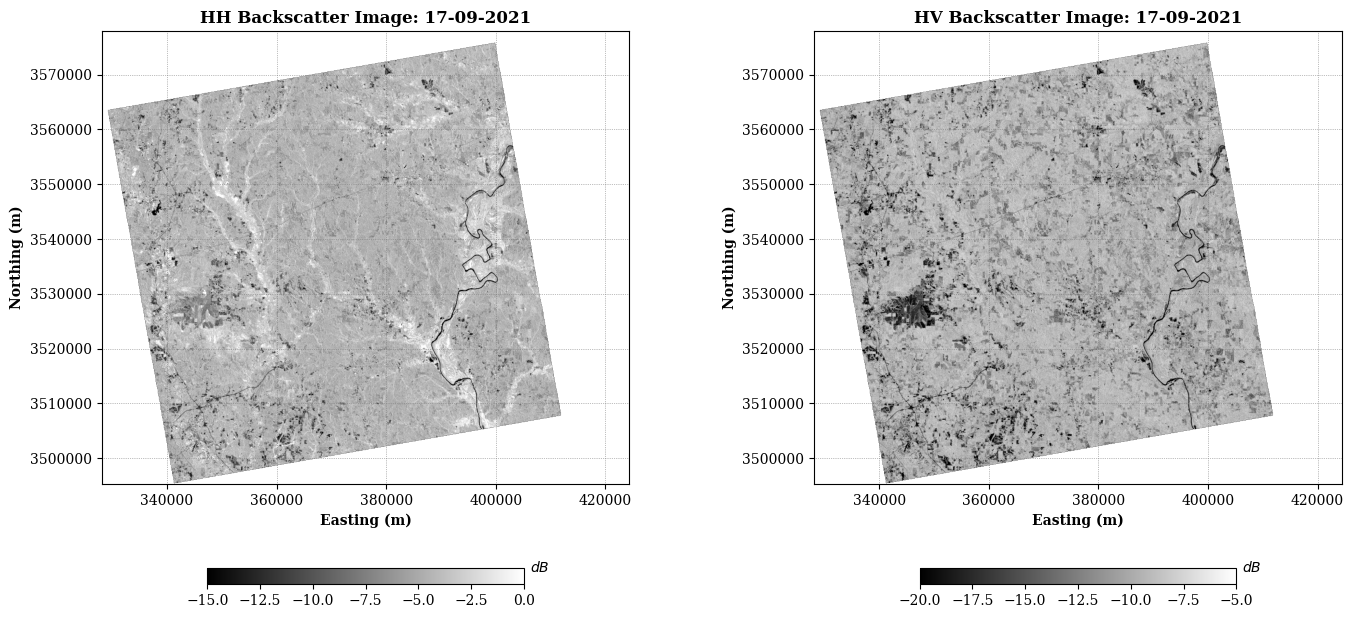

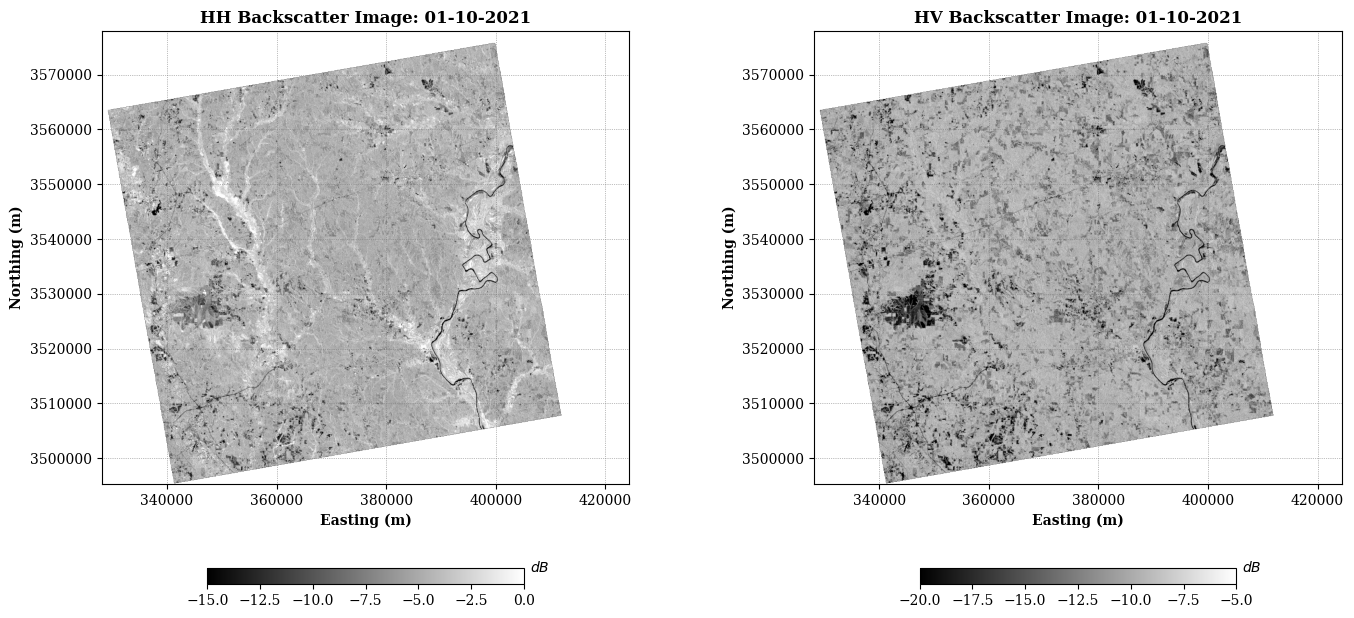

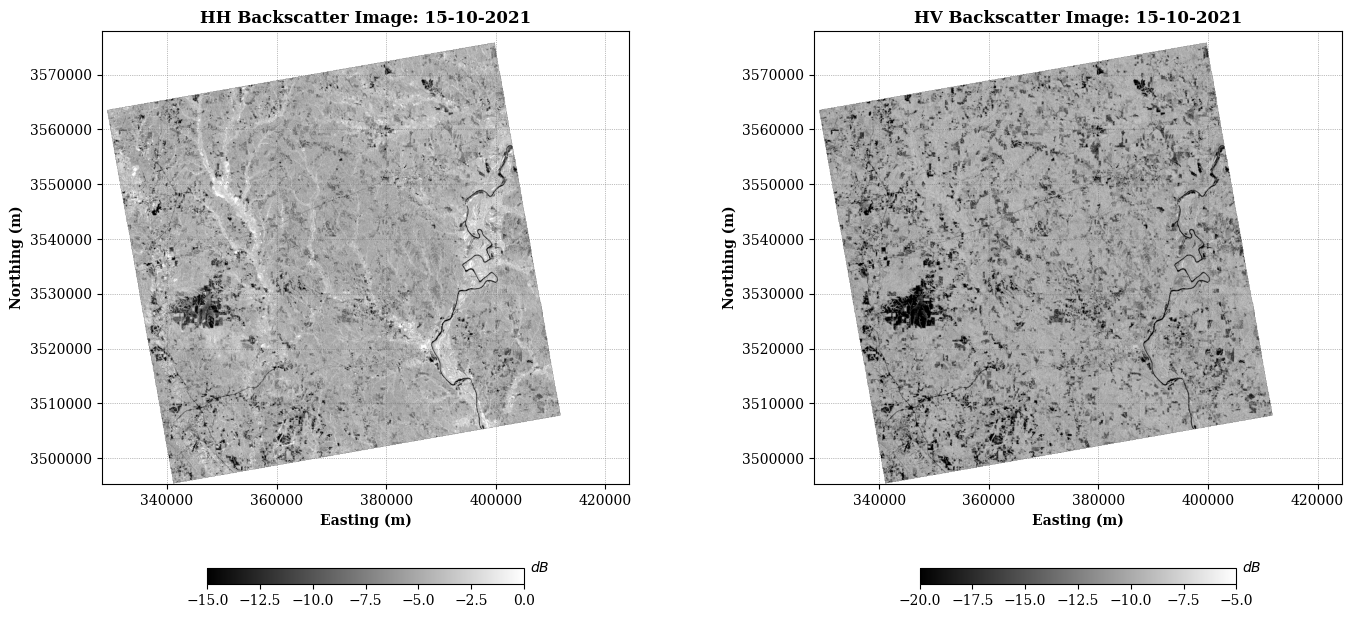

In [77]:

# PLOT EACH SAR IMAGES FROM THE FILTERED DATASET
for NUM in range(NUM_SCENES): #
    plt.rcParams['font.family'] = 'serif'  # SET DEFAULT FONT FAMILY FOR FIGURE 
    plt.rcParams['font.serif'] = ['DejaVu Serif']  # SET THE PRIMARY FONT FOR ALL SERIF TEXT IN THE FIGURE  
    plt.rcParams['font.size'] = 10  # SET FONT SIZE 
    
    # CREATES A FIGURE AND A GRID FOR SUBPLOTS 
    fig, ax = plt.subplots(1, 2, figsize=(16, 11)) 
    
    # LOAD THE HH IMAGE
    HH_INFO = gdal.Open(HH_FILES[NUM]) # LOAD THE HH IMAGE
    GAMMA_HH = HH_INFO.GetRasterBand(1).ReadAsArray()
    GAMMA_HH[GAMMA_HH < 0.0001] = np.nan
    GAMMA_HH = 10 * np.log10(GAMMA_HH) # READ THE HH DATA INTO ARRAY  
    
    # LOAD THE HV IMAGE
    HV_INFO = gdal.Open(HV_FILES[NUM]) # LOAD THE HH IMAGE
    GAMMA_HV = HV_INFO.GetRasterBand(1).ReadAsArray()
    GAMMA_HV[GAMMA_HV < 0.0001] = np.nan
    GAMMA_HV = 10 * np.log10(GAMMA_HV) # READ THE HH DATA INTO ARRAY  
    
    # GET THE EXTENT OF THE IMAGE  
    X_MIN, X_MAX, Y_MIN, Y_MAX = fn.GetExtent(HH_INFO)   
    # GET THE DATE OF THE IMAGE IN DD-MM-YYYY FORMAT
    DATE = SAR_DATA_ID.DATES.iloc[NUM].strftime("%d-%m-%Y") 
    
    # DISPLAYS THE HH IMAGE 
    im = ax[0].imshow(
        GAMMA_HH,
        cmap = "gray",
        vmin = -15,
        vmax = 0,
        extent = [X_MIN, X_MAX, Y_MIN, Y_MAX],
    )
    # ADD THE GRID TO IMAGE 
    ax[0].grid(True, which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, zorder=1) 
    # ADD THE TITLE TO IMAGE 
    ax[0].set_title("HH Backscatter Image: " + DATE, fontweight = 'bold')
    # ADD THE XLABEL TO IMAGE 
    ax[0].set_xlabel('Easting (m)', fontweight = 'bold')
    # ADD THE YLABEL TO IMAGE 
    ax[0].set_ylabel('Northing (m)',  fontweight = 'bold')
    # FORMAT THE XTICK VALUES TO TWO DECIMALS
    ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
    # FORMAT THE YTICK VALUES TO TWO DECIMALS
    ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
    # ADDS A COLORBAR 
    cbar = ax[0].figure.colorbar(im, ax=ax[0], shrink=0.6, orientation='horizontal', pad=0.1)
    # CUSTOMIZING THE COLOR BAR LABEL 
    cbar.set_label('$dB$', labelpad=-35, x = 1.05, y = 1.1, rotation=0)
    
    # DISPLAYS THE HV IMAGE 
    im = ax[1].imshow(
        GAMMA_HV,
        cmap = "gray",
        vmin = -20,
        vmax = -5,
        extent = [X_MIN, X_MAX, Y_MIN, Y_MAX],
    )
    # ADD THE GRID TO IMAGE 
    ax[1].grid(True, which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, zorder=1) 
    # ADD THE TITLE TO IMAGE 
    ax[1].set_title("HV Backscatter Image: " + DATE, fontweight = 'bold')
    # ADD THE XLABEL TO IMAGE 
    ax[1].set_xlabel('Easting (m)', fontweight = 'bold')
    # ADD THE YLABEL TO IMAGE 
    ax[1].set_ylabel('Northing (m)',  fontweight = 'bold')
    # FORMAT THE XTICK VALUES TO TWO DECIMALS
    ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
    # FORMAT THE YTICK VALUES TO TWO DECIMALS
    ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
    # ADDS A COLORBAR 
    cbar = ax[1].figure.colorbar(im, ax=ax[1], shrink=0.6, orientation='horizontal', pad=0.1)
    # CUSTOMIZING THE COLOR BAR LABEL 
    cbar.set_label('$dB$', labelpad=-35, x = 1.05, y = 1.1, rotation=0)
    
    # ADJUST HORIZONTAL AND VERTICAL SPACING BETWEEN SUBPLOTS 
    plt.subplots_adjust(wspace=0.35, hspace=0.25)
    # SAVE THE FIGURE 
    plt.savefig(META_DIR / Path(SITE + "_SAR_Backscatter_" + DATE + ".png"), dpi=600, bbox_inches='tight')
    

#### PLOT STATISTIC OF EACH SAR IMAGES FROM THE FILTERED DATASET

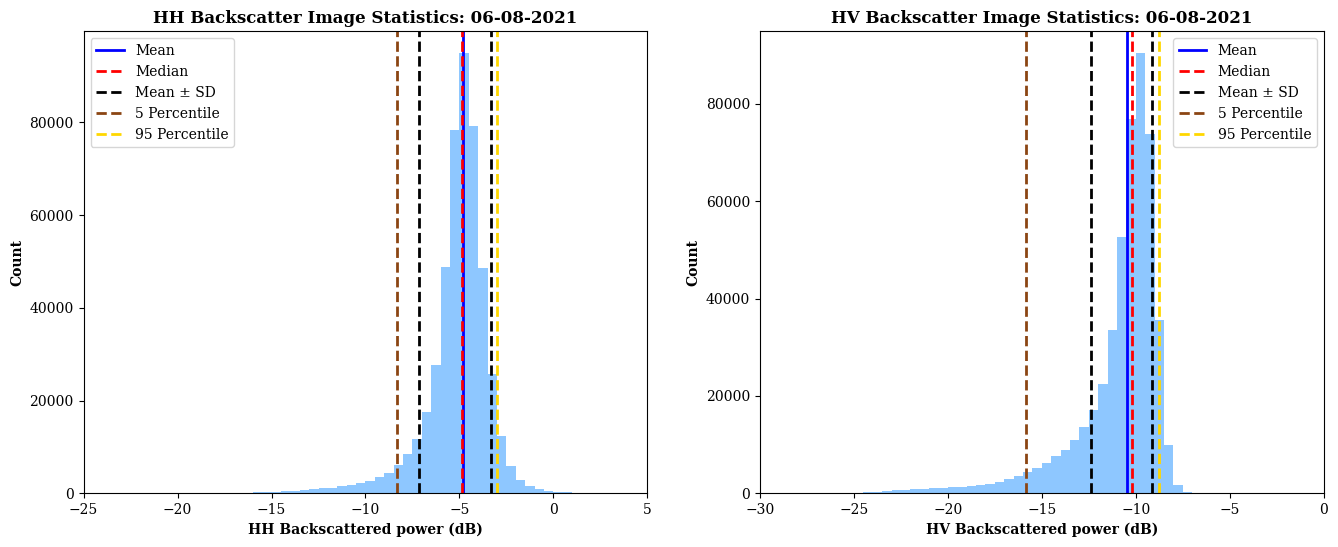

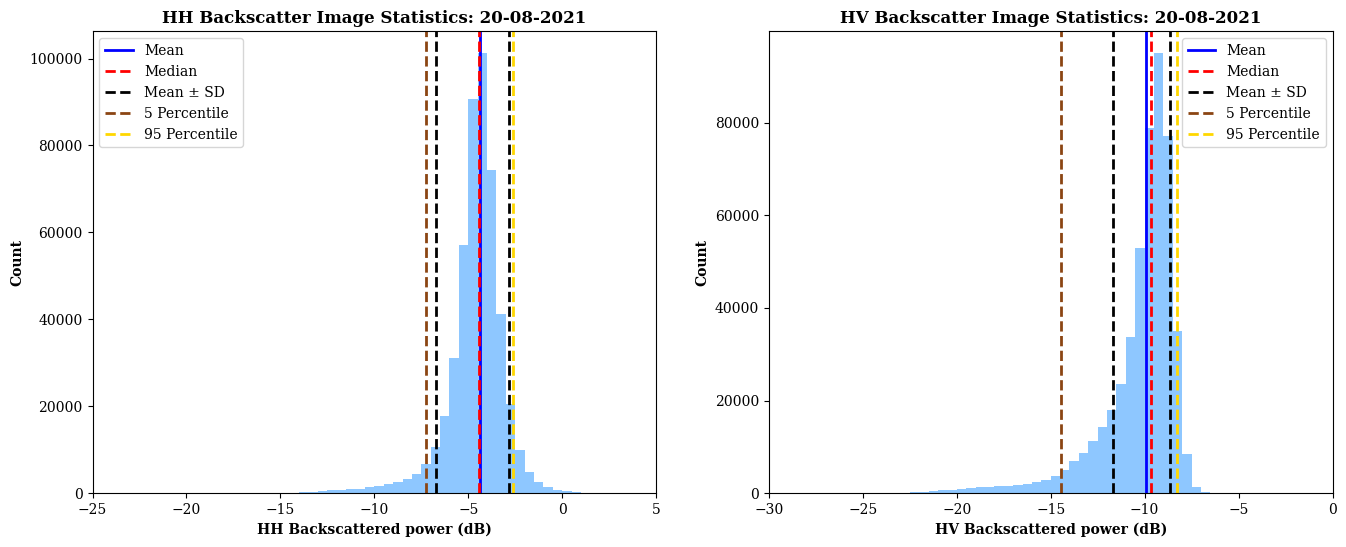

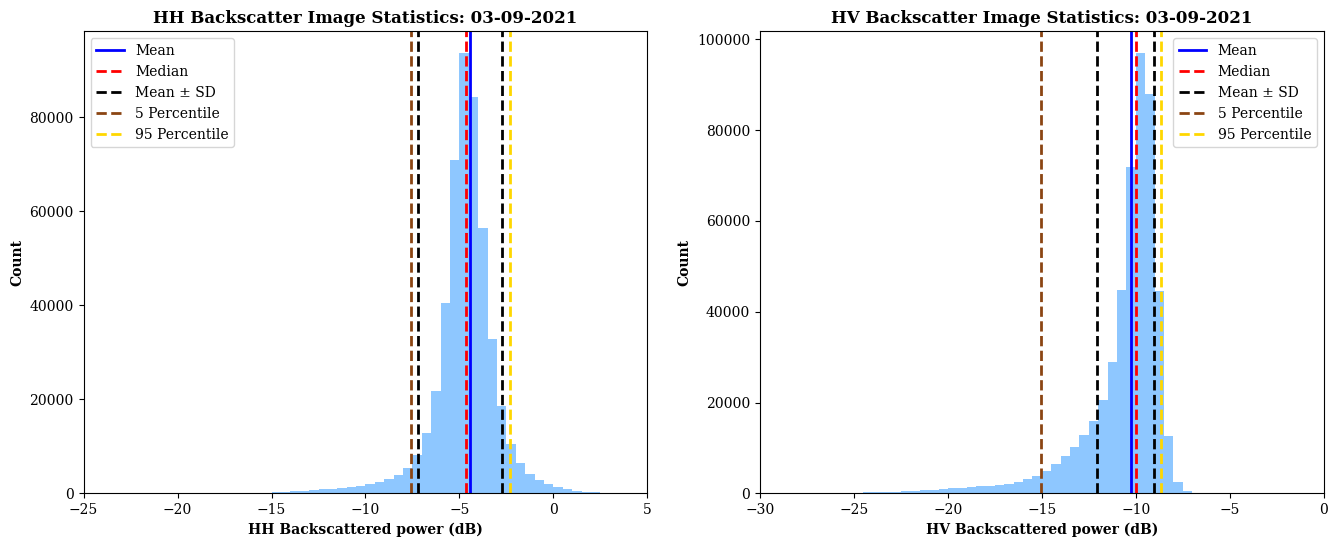

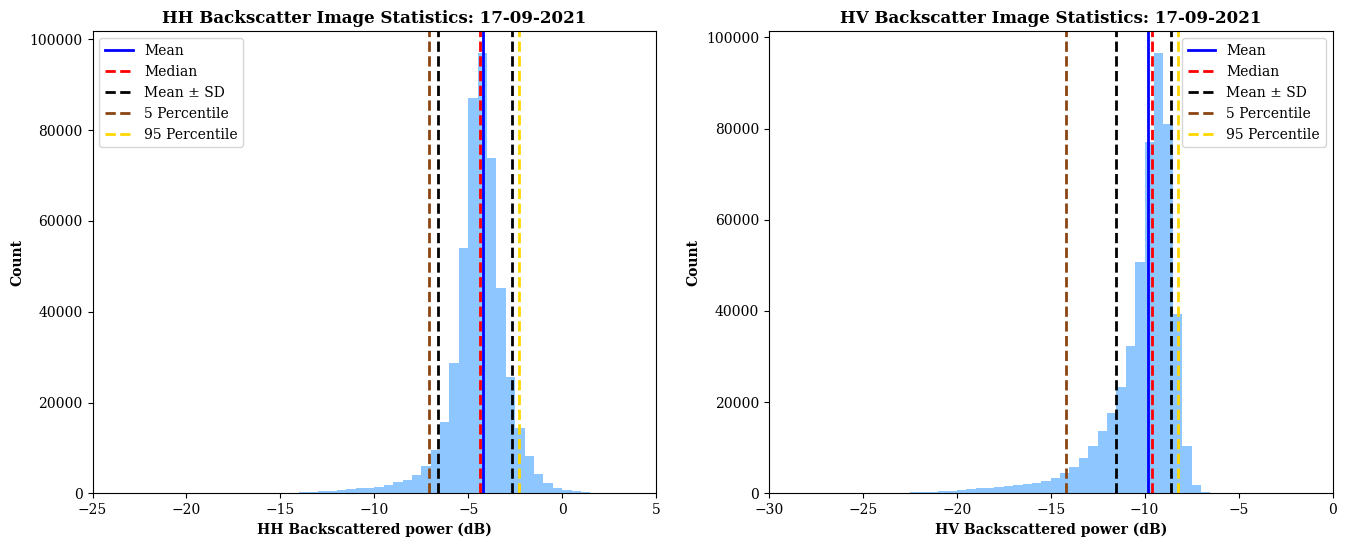

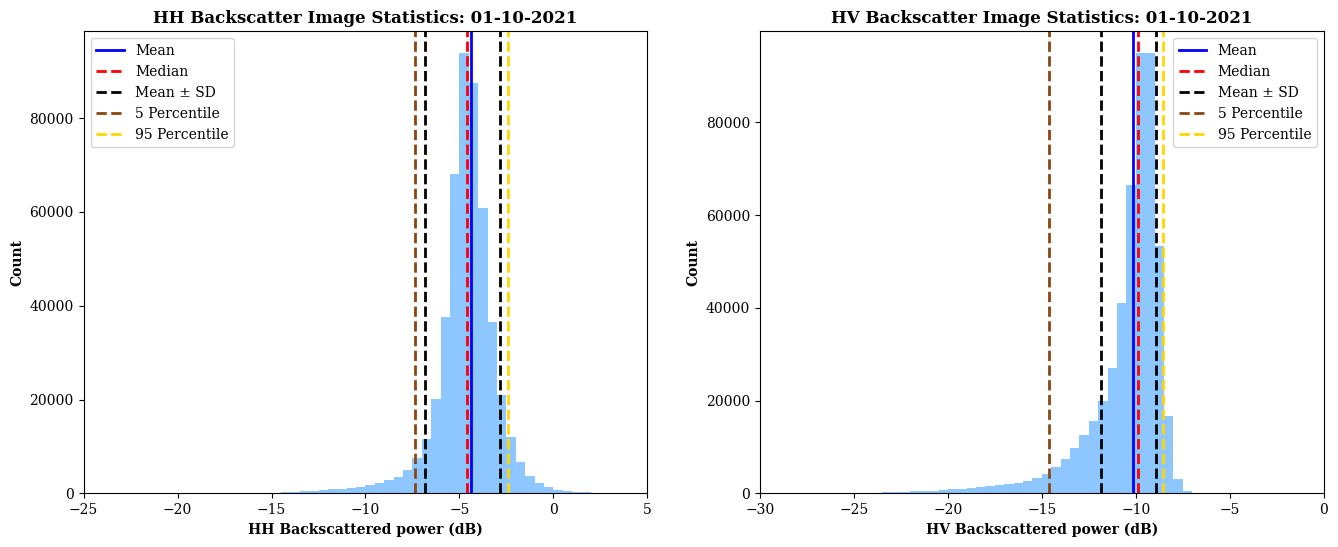

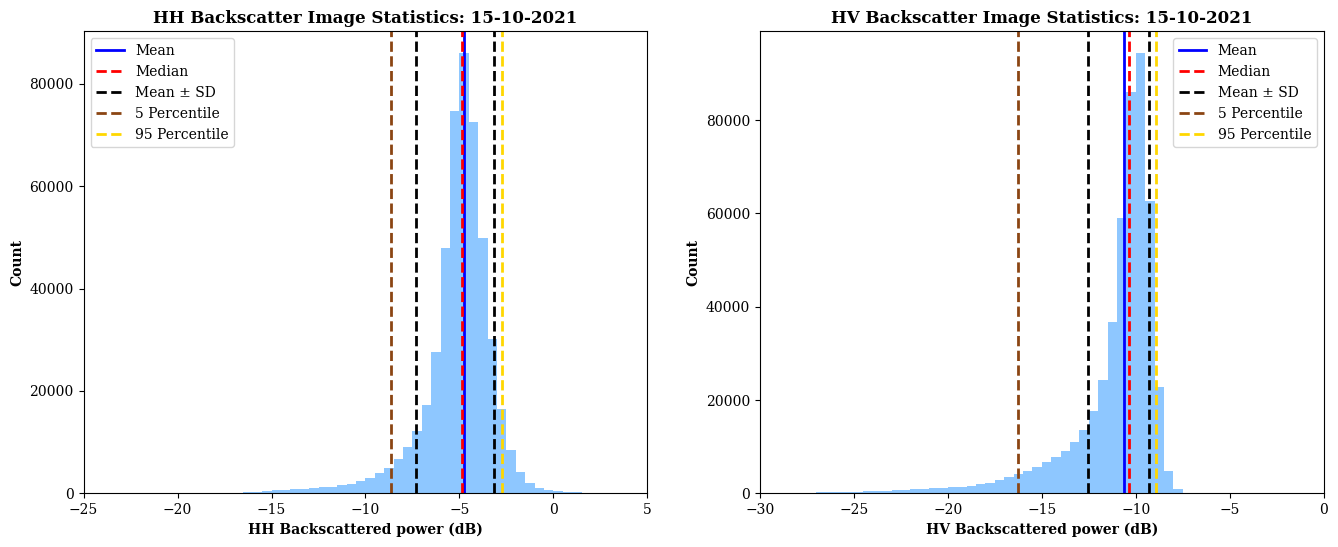

In [78]:
# PLOT STATISTICS OF EACH SAR IMAGES FROM THE FILTERED DATASET
for NUM in range(NUM_SCENES):
    plt.rcParams['font.family'] = 'serif'  # SET DEFAULT FONT FAMILY FOR FIGURE 
    plt.rcParams['font.serif'] = ['DejaVu Serif']  # SET THE PRIMARY FONT FOR ALL SERIF TEXT IN THE FIGURE  
    plt.rcParams['font.size'] = 10  # SET FONT SIZE 
    
    # CREATES A FIGURE AND A GRID FOR SUBPLOTS 
    fig, ax = plt.subplots(1, 2, figsize=(16, 6)) 
    
    # LOAD THE HH IMAGE
    HH_INFO = gdal.Open(HH_FILES[NUM]) # LOAD THE HH IMAGE
    GAMMA_HH = HH_INFO.GetRasterBand(1).ReadAsArray()
    GAMMA_HH[GAMMA_HH < 0.0001] = np.nan
    GAMMA_HH = 10 * np.log10(GAMMA_HH) # READ THE HH DATA INTO ARRAY  
    
    # LOAD THE HV IMAGE
    HV_INFO = gdal.Open(HV_FILES[NUM]) # LOAD THE HH IMAGE
    GAMMA_HV = HV_INFO.GetRasterBand(1).ReadAsArray()
    GAMMA_HV[GAMMA_HV < 0.0001] = np.nan
    GAMMA_HV = 10 * np.log10(GAMMA_HV) # READ THE HH DATA INTO ARRAY  
    
    # GET THE DATE OF THE IMAGE IN DD-MM-YYYY FORMAT
    DATE = SAR_DATA_ID.DATES.iloc[NUM].strftime("%d-%m-%Y")  
    
    #GAMMA_HH_CLIP   = GAMMA_HH[(GAMMA_HH > np.nanpercentile(GAMMA_HH, 5))  & (GAMMA_HH < np.nanpercentile(GAMMA_HH, 95))]
    GAMMA_HH_CLIP = GAMMA_HH
    #  CREATES A HISTOGRAM FOR HH SAR IMAGE 
    im = ax[0].hist(GAMMA_HH_CLIP.flatten(), bins = np.arange(-25, 5, 0.5), color = 'dodgerblue', alpha = 0.5)
    #  PLOTS THE MEAN VALUE OF HH SAR IMAGE 
    ax[0].axvline(10*np.log10(DF_HH.iloc[NUM]['MEAN']),   color='blue',    linestyle='-', linewidth=2, label = 'Mean')
    #  PLOTS THE MEDIAN VALUE OF HH SAR IMAGE 
    ax[0].axvline(10*np.log10(DF_HH.iloc[NUM]['MEDIAN']), color='red', linestyle='--', linewidth=2, label = 'Median')
    #  PLOTS THE MEAN + SD VALUE OF HH SAR IMAGE 
    ax[0].axvline(10*np.log10(DF_HH.iloc[NUM]['MEAN'] - DF_HH.iloc[NUM]['SD']), color='k', linestyle='--', linewidth=2, label = 'Mean ± SD')
    #  PLOTS THE MEAN - SD VALUE OF HH SAR IMAGE 
    ax[0].axvline(10*np.log10(DF_HH.iloc[NUM]['MEAN'] + DF_HH.iloc[NUM]['SD']), color='k', linestyle='--', linewidth=2)
    #  PLOTS THE 1 PERCENTILE  VALUE OF HH SAR IMAGE 
    ax[0].axvline(np.nanpercentile(GAMMA_HH, 5),  color = 'saddlebrown', linestyle='--',  linewidth=2, label = '5 Percentile')
    #  PLOTS THE 99 PERCENTILE  VALUE OF HH SAR IMAGE 
    ax[0].axvline(np.nanpercentile(GAMMA_HH, 95), color = 'gold', linestyle='--',  linewidth=2, label = '95 Percentile')
    # ADD THE TITLE TO IMAGE 
    ax[0].set_title("HH Backscatter Image Statistics: " + DATE, fontweight = 'bold')
    # ADD THE XLABEL TO IMAGE 
    ax[0].set_xlabel('HH Backscattered power (dB)', fontweight = 'bold')
    # ADD THE YLABEL TO IMAGE 
    ax[0].set_ylabel('Count',  fontweight = 'bold')
    # SET THE XLIM 
    ax[0].set_xlim([-25, 5])
    # ADD THE LEGEND  
    ax[0].legend()
    
    #GAMMA_HV_CLIP  = GAMMA_HV[(GAMMA_HV > np.nanpercentile(GAMMA_HV, 5))  & (GAMMA_HV < np.nanpercentile(GAMMA_HV, 95))]
    GAMMA_HV_CLIP  = GAMMA_HV
    #  CREATES A HISTOGRAM FOR HV SAR IMAGE 
    im = ax[1].hist(GAMMA_HV_CLIP.flatten(), bins= np.arange(-30, 0, 0.5), color = 'dodgerblue', alpha = 0.5)
    #  PLOTS THE MEAN VALUE OF HV SAR IMAGE 
    ax[1].axvline(10*np.log10(DF_HV.iloc[NUM]['MEAN']),   color='blue',    linestyle='-', linewidth=2, label = 'Mean')
    #  PLOTS THE MEDIAN VALUE OF HV SAR IMAGE 
    ax[1].axvline(10*np.log10(DF_HV.iloc[NUM]['MEDIAN']), color='red', linestyle='--', linewidth=2, label = 'Median')
    #  PLOTS THE MEAN + SD VALUE OF HV SAR IMAGE 
    ax[1].axvline(10*np.log10(DF_HV.iloc[NUM]['MEAN'] - DF_HV.iloc[NUM]['SD']), color='k', linestyle='--', linewidth=2, label = 'Mean ± SD')
    #  PLOTS THE MEAN - SD VALUE OF HV SAR IMAGE 
    ax[1].axvline(10*np.log10(DF_HV.iloc[NUM]['MEAN'] + DF_HV.iloc[NUM]['SD']), color='k', linestyle='--', linewidth=2)
    #  PLOTS THE 1 PERCENTILE  VALUE OF HV SAR IMAGE 
    ax[1].axvline(np.nanpercentile(GAMMA_HV, 5),  color = 'saddlebrown', linestyle='--',  linewidth=2, label = '5 Percentile')
    #  PLOTS THE 99 PERCENTILE  VALUE OF HV SAR IMAGE 
    ax[1].axvline(np.nanpercentile(GAMMA_HV, 95), color = 'gold', linestyle='--',  linewidth=2, label = '95 Percentile')
    # ADD THE TITLE TO IMAGE 
    ax[1].set_title("HV Backscatter Image Statistics: " + DATE, fontweight = 'bold')
    # ADD THE XLABEL TO IMAGE 
    ax[1].set_xlabel('HV Backscattered power (dB)', fontweight = 'bold')
    # ADD THE YLABEL TO IMAGE 
    ax[1].set_ylabel('Count',  fontweight = 'bold')
    # SET THE XLIM 
    ax[1].set_xlim([-30, 0])
    # ADD THE LEGEND  
    ax[1].legend()
    
    # ADJUST HORIZONTAL AND VERTICAL SPACING BETWEEN SUBPLOTS 
    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    # SAVE THE FIGURE 
    plt.savefig(META_DIR / Path(SITE  + "_SAR_Backscatter_Statistics_" + DATE + ".png"), dpi=600, bbox_inches='tight')
    

In [79]:
##### Enable all the cells below if you are independently running each notebooks

In [80]:
##### FILTER THE DATA, CREATE METADATA FILE, VERSION NUMBER AND FILE NAME 

In [81]:
#### FILTER THE SAR DATASET 
DF = pd.read_csv(META_DIR / Path(SITE + '_nisarsimulated_Data_List.csv'))

# REMOVE THE DATES YOU WANT TO EXCLUDE FROM THE PROCESSING 
DF_FILTERED = fn.filter_data(DF)

# VIEW THE FILTERED DATALIST 
display(DF_FILTERED)

Enter an index (e.g., 1) / a list of indices separated by spaces or commas (e.g., 1, 5) / range of indices (e.g., 1-5):  



No filtering applied. Returning original DataFrame.


DATES  \
0  2021-08-06   
1  2021-08-20   
2  2021-09-03   
3  2021-09-17   
4  2021-10-01   
5  2021-10-15   

                                                                                                                                                           PRODUCT_ID  
0  /home/jovyan/NISAR_ATBD_AGB/data_repo/data/nisar_simulated/TestSite/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777.h5  
1  /home/jovyan/NISAR_ATBD_AGB/data_repo/data/nisar_simulated/TestSite/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777.h5  
2  /home/jovyan/NISAR_ATBD_AGB/data_repo/data/nisar_simulated/TestSite/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777.h5  
3  /home/jovyan/NISAR_ATBD_AGB/data_repo/data/nisar_simulated/TestSite/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777.h5  
4  /home/jovyan/NISAR_ATBD_AGB/data_repo/data/nisar_simulated/TestSite/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777.h5  
5  /home/jovyan/NISAR_ATBD_AGB/data_repo/data/nisar_simulated/TestSite/NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777.h5

In [82]:
# FIND THE VERSION NUMBER OF FILE IF PREVIOUS RUN EXISTS
V_N = str(fn.get_version_number(str(META_DIR), OVERWRITE = True)).zfill(3)

### CREATE THE NEW FILE NAME FOR THE CURRENT RUN
FILE_NAME  = 'NISAR_L_3_40_A_AGB_'  + f"{datetime.strptime(DF_FILTERED['DATES'].iloc[0], "%Y-%m-%d").date().month:02}" + '_' + f"{datetime.strptime(DF_FILTERED['DATES'].iloc[-1], "%Y-%m-%d").date().month:02}" + '_' + f"{datetime.strptime(DF_FILTERED['DATES'].iloc[-1], "%Y-%m-%d").date().year % 100:02}" + '_' + SITE + '_' + f"{V_N:03}" + '_' + str(datetime.now().strftime("%Y%m%d")) 

# SAVE THE LIST OF FILTERED SAR DATA LIST TO CSV
DF_FILTERED.to_csv(META_DIR / Path(FILE_NAME + '_FILTERED_DATA.csv'), index=False)

print('The Filename is ' + FILE_NAME)

The Filename is NISAR_L_3_40_A_AGB_08_10_21_TestSite_000_20251020


In [83]:
#### OUTPUT DIRECTORY 
OUT_DIR = OUTDIR_DIR / FILE_NAME  
os.makedirs(OUT_DIR, exist_ok='True')  # CREATES OUTPUT DIRECTORY IF NOT EXISTING 

In [84]:
SAR_RES_DATA_LIST = [os.path.basename(x) for x in  list(pd.read_csv(META_DIR / Path(SITE + '_nisarsimulated_Band_List.csv'))['DATA_ID'])]# OPEN AND READ THE CSV FILE
DF_FILTERED_LIST = [os.path.basename(x).split('.h5')[0] for x in DF_FILTERED['PRODUCT_ID'].tolist()]
# Find strings containing any of the substrings
SAR_RES_DATA_LIST = [GCOV_STACKS_DIR / s for s in SAR_RES_DATA_LIST if any(sub in s for sub in DF_FILTERED_LIST)]
print((DF_FILTERED_LIST))


['NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777', 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777', 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777', 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777', 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777', 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777']


In [85]:
# FILTER THE HH STATISTICS
DF_HV_FILTERED = DF_HV[DF_HV['BAND_NAME'].isin(DF_FILTERED_LIST)]
# WRITE THE DATAFRAME OF FILTERED HH IMAGE STATISTICS TO CSV FILE
DF_HV_FILTERED.to_csv(OUT_DIR / Path(FILE_NAME + "_HV_STATS.csv")) 
# VIEW THE FILTERED DATALIST 
display(DF_HV_FILTERED)
 

BAND  \
0    1   
1    2   
2    3   
3    4   
4    5   
5    6   

                                                                                     BAND_NAME  \
0  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777   
1  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777   
2  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777   
3  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777   
4  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777   
5  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777   

      MIN     MAX    MEAN  MEDIAN      SD  SKEWNESS  KURTOSIS  
0  0.0015  0.8523  0.0896  0.0952  0.0319   -0.5604    0.7240  
1  0.0017  0.9257  0.1021  0.1078  0.0339   -0.5827    0.9201  
2  0.0017  0.9552  0.0939  0.0997  0.0315   -0.6145    1.4369  
3  0.0018  0.8125  0.1041  0.1096  0.0338   -0.5949    0.6866  
4  0.0017  0.8909  0.0965  0.1022  0.0314   -0.6217    1.1622  
5  0.0015  0.8313  0.0863  0.0924  0.0308   -0.6327    0.8431

In [86]:
# FILTER THE HH STATISTICS
DF_HH_FILTERED = DF_HH[DF_HH['BAND_NAME'].isin(DF_FILTERED_LIST)]
# WRITE THE DATAFRAME OF FILTERED HH IMAGE STATISTICS TO CSV FILE
DF_HH_FILTERED.to_csv(OUT_DIR / Path(FILE_NAME + "_HH_STATS.csv")) 
# VIEW THE FILTERED DATALIST 
display(DF_HH_FILTERED)



BAND  \
0    1   
1    2   
2    3   
3    4   
4    5   
5    6   

                                                                                     BAND_NAME  \
0  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210806T054757_20210806T054807_T00777_M_F_J_777   
1  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210820T054757_20210820T054807_T00777_M_F_J_777   
2  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210903T054757_20210903T054807_T00777_M_F_J_777   
3  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20210917T054757_20210917T054807_T00777_M_F_J_777   
4  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211001T054757_20211001T054807_T00777_M_F_J_777   
5  NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20211015T054757_20211015T054807_T00777_M_F_J_777   

      MIN        MAX    MEAN  MEDIAN      SD  SKEWNESS    KURTOSIS  
0  0.0054  42.688099  0.3296  0.3265  0.1379   65.1217  18365.0834  
1  0.0059  44.370201  0.3661  0.3594  0.1523   62.4778  15084.4252  
2  0.0059  45.435799  0.3621  0.3439  0.1722   43.1974   9737.7713  
3  0.0065  45.914600  0.3791  0.3659  0.1620   57.4714  13487.6851  
4  0.0055  47.172100  0.3639  0.3490  0.1574   59.0215  16024.8275  
5  0.0057  44.240799  0.3344  0.3272  0.1489   55.9181  15429.0118

### 4. 2. Create Forest/Non-Forest Mask

### Overview of Tasks Performed
> 1. **Create Forest/Non-Forest Mask** : In this section, we will create a Forest/Non-Forest Mask to distinguish forested areas from non-forested regions based on specific criteria. The process involves leveraging NLCD land cover data, SAR backscatter values, and LiDAR AGB value to accurately classify pixels as either forest or non-forest. Once the mask is created, it can be applied to filter the data and model forest biomass.
>

In [87]:
# Year of LULC Data
LULC_YYYY = 2021 
# Name of LULC Data
LULC_NAME = 'NLCD'

In [88]:
IN_LULC_FILE = '/home/jovyan/data_backup/leno_nlcd_2021.tif'
# OUTPUT PATH TO THE RESAMPLED LULC MAP
OUT_LULC_FILE = LULC_DIR  / Path(LULC_NAME + '_' + str(LULC_YYYY) + '_' + SITE + '_100m.tif')    

# RESAMPLE THE LULC MAP FILE BY TAKING MODE OVER 100 m X100 m GRID OF REFERENCE IMAGE  
fn.raster_clip(REFERENCE_FILE, IN_LULC_FILE, OUT_LULC_FILE, resampling_method = "mode")

gdalwarp -s_srs "+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs" -t_srs "+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs" -te 328110.0 3495330.0 424410.0 3577930.0 -ts 963 826 -srcnodata nan -dstnodata nan -overwrite -multi -co COMPRESS=DEFLATE -co ZLEVEL=1 -co PREDICTOR=2 -co BIGTIFF=YES -r mode -ot Float32 "/home/jovyan/data_backup/leno_nlcd_2021.tif" "/home/jovyan/NISAR_ATBD_AGB/data_repo/processing/nisar_simulated/TestSite/LULC/NLCD_2021_TestSite_100m.tif"


##### Plot resampled NLCD Map

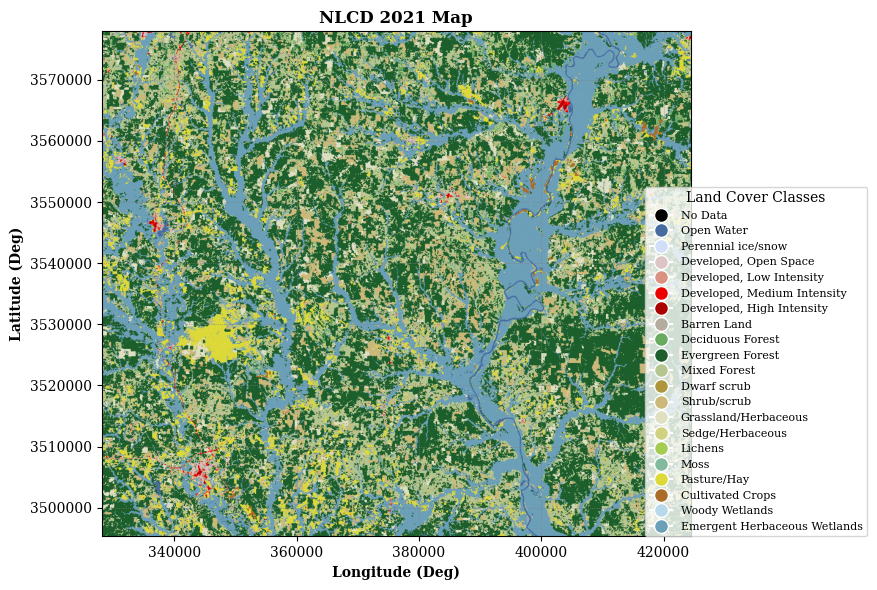

In [89]:

# PLOT LULC IMAGE
DATA_INFO = gdal.Open(OUT_LULC_FILE)
# READ AGB VALUES TO ARRAY 
LULC =  DATA_INFO.GetRasterBand(1).ReadAsArray()
# GET THE NLCD PALATTE 
HF = fn.get_color_palette_nlcd()
# CREATE A CUSTOM COLORMAP
CMAP = mpl.colors.ListedColormap(list(HF['Palette'].values))



NORM = mpl.colors.BoundaryNorm(list(HF['Value'].values), ncolors=len(list(HF['Palette'].values)))

plt.rcParams['font.family'] = 'DejaVu Serif'  # SET DEFAULT FONT FAMILY FOR FIGURE 
plt.rcParams['font.serif'] = ['Times New Roman']  # SET THE PRIMARY FONT FOR ALL SERIF TEXT IN THE FIGURE  
plt.rcParams['font.size'] = 10  # SET FONT SIZE 
    
# CREATES A FIGURE 
fig, ax = plt.subplots(figsize=(14, 6)) 
# DISPLAYS THE LULC IMAGE
im = plt.imshow(
    LULC,
    cmap = CMAP,
    norm = NORM, 
    extent = [X_MIN, X_MAX, Y_MIN, Y_MAX],
)
# ADD THE GRID TO IMAGE 
ax.grid(True, which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, zorder=1) 
# ADD THE TITLE TO IMAGE 
ax.set_title(LULC_NAME + " " + str(LULC_YYYY) + " Map", fontweight = 'bold')
# ADD THE XLABEL TO IMAGE 
ax.set_xlabel('Longitude (Deg)', fontweight = 'bold')
# ADD THE YLABEL TO IMAGE 
ax.set_ylabel('Latitude (Deg)',  fontweight = 'bold')
# FORMAT THE XTICK VALUES TO TWO DECIMALS
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
# FORMAT THE YTICK VALUES TO TWO DECIMALS
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
# CREATE HANDLES FOR LEGEND
handles = []
for index, row in HF.iterrows():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=row['Description'],
                                markerfacecolor=row['Palette'], markersize=10))
# DISPLAY THE LEGEND
ax.legend(handles=handles, title="Land Cover Classes", loc='lower right',
          bbox_to_anchor=(1.3, 0), fontsize=8, borderaxespad=0.)
# ADJUST PADDING AROUND THE IMAGE
plt.tight_layout()
# SAVE THE FIGURE 
plt.savefig(OUT_DIR  / Path(SITE + "_LULC.png"), dpi=600, bbox_inches='tight')

##### Create the mask file with  AGB pixels greater than 0 Mg/ha and valid HH and HV observations 

1. Compute the minimum (HHmin, Hvmin) and maximum (HHmax, Hvmax) values of the backscatter for every pixel in the image over the entire time series.
2. Generate a backscatter mask by selecting pixels that have an HVmin value greater than the threshold value, and an HHmax and HVmax value less than 1.
3. Utilize the Landcover data to create a Land Use/Land Cover (LULC) mask that excludes water, man-made, and non-vegetation classes. 
4. Use the LIDAR AGB Map to create a mask that excludes non-AGB values. 
4. Finally, combine the backscatter mask, LULC mask, and X mask to generate the FNF mask.

##### Load the SAR data files

In [90]:
SAR_RES_DATA_LIST = [os.path.basename(x) for x in  list(pd.read_csv(META_DIR / Path(SITE + '_nisarsimulated_Band_List.csv'))['DATA_ID'])]# OPEN AND READ THE CSV FILE
DF_FILTERED = pd.read_csv(META_DIR / Path(FILE_NAME + '_FILTERED_DATA.csv'))
DF_FILTERED_LIST = [os.path.basename(x).split('.h5')[0] for x in DF_FILTERED['PRODUCT_ID'].tolist()]
# Find strings containing any of the substrings
SAR_RES_DATA_LIST = [GCOV_STACKS_DIR / s for s in SAR_RES_DATA_LIST if any(sub in s for sub in DF_FILTERED_LIST)]

HH_FILES = []  # INITIALIZE THE HH FILE LIST
HV_FILES = []  # INITIALIZE THE HV FILE LIST
# CALCULATE NUMBER OF SCENES
NUM_SCENES = int(len(SAR_RES_DATA_LIST)/2)

for NUM in range(NUM_SCENES):
    # HH data 
    HV_FILES.append(SAR_RES_DATA_LIST[NUM*2 + 0]) # APPEND THE HV FILES 
    # HV data 
    HH_FILES.append(SAR_RES_DATA_LIST[NUM*2 + 1]) # APPEND THE HH FILES 


##### Create Minimum and Maximum Backscatter layers

In [91]:
# CREATE HV MIN AND MAX LAYER 
DA_HV = []
# PLOT STATISTICS OF EACH SAR IMAGES FROM THE FILTERED DATASET
for NUM in range(NUM_SCENES):
    # LOAD THE HV IMAGE
    HV_INFO = gdal.Open(HV_FILES[NUM]) # LOAD THE HH IMAGE
    GAMMA_HV = HV_INFO.GetRasterBand(1).ReadAsArray() # READ THE HH DATA INTO ARRAY  
    DA_HV.append(GAMMA_HV) # APPEND THE HV LAYER
    
HV_MIN = np.min(np.array(DA_HV), axis=0) # ESTIMATE MIN OF THE HV LAYER ACROSS TIMESERIES
HV_MAX = np.max(np.array(DA_HV), axis=0) # ESTIMATE MAX OF THE HV LAYER ACROSS TIMESERIES


# CREATE HH MIN AND MAX LAYER 
DA_HH = []
for NUM in range(NUM_SCENES):
    # LOAD THE HV IMAGE
    HH_INFO = gdal.Open(HH_FILES[NUM]) # LOAD THE HH IMAGE
    GAMMA_HH = HH_INFO.GetRasterBand(1).ReadAsArray() # READ THE HH DATA INTO ARRAY  
    DA_HH.append(GAMMA_HH) # APPEND THE HH LAYER
    
HH_MIN = np.min(np.array(DA_HH), axis=0) # ESTIMATE MIN OF THE HH LAYER ACROSS TIMESERIES
HH_MAX = np.max(np.array(DA_HH), axis=0) # ESTIMATE MAX OF THE HH LAYER ACROSS TIMESERIES

In [92]:
# CREATE A SAR MASK WITH VALID HH AND HV VALUES FROM MIN MAX LAYERS 
SAR_MASK = np.where((HV_MIN > 0.01) & (HV_MAX < 1) & (HH_MAX < 1), 1, 0)

In [93]:
# CREATE A LULC MASK
LULC_MASK = (LULC != 11) & (LULC != 12) &  (LULC != 22) & (LULC != 23) & (LULC != 24)  

In [94]:
# CREATE A FNF MASK
MASK = np.where((SAR_MASK == 1) & (LULC_MASK == 1), 1, 0)
MASK_FILE = OUT_DIR / Path(FILE_NAME + "_mask_100m.tif") # CREATE A PATH TO SAVE THE MASK LAYER
fn.write_geotiff_with_gdalcopy(REFERENCE_FILE, MASK, MASK_FILE) # SAVE THE MASK FILE


### 4. 3. Loading Calibrated Model & initial AGB Estimation

### Overview of Tasks Performed
> 1. **Initial Aboveground Biomass Estimation** : Initial estimates of AGB was estimated. Here HV polarizations values are used to estimate AGB values. 
> 2. **Load the NISAR Biomass Model Parameters** : The initial estimate of NISAR biomass model parameters is a crucial step in developing accurate predictive model. In this study, initial estimates of the NISAR biomass model parameters are derived from the mean values of time series data gathered at the calibration site. These mean values, which capture the average trends and fluctuations of backscatter over time, provide a strong starting point for model calibration for time series estimation.

### Estimate the initial AGB values

In [95]:
# OUTPUT PATH TO THE FNF MAP
MASK_FILE_100 = OUT_DIR / Path(FILE_NAME + "_mask_100m.tif")
# Estimate the initial AGB map
mr.initial_agb_estimation(OUT_DIR, MASK_FILE, MASK_FILE, None, SAR_RES_DATA_LIST, FILE_NAME)

### Load the calibration parameters

In [98]:
# Create configparser object
CONFIG = configparser.ConfigParser()

# Read the ini file
CONFIG.read(MAIN_DIR / Path('config/config.ini'))


PARAM  = CONFIG['NISAR'] 
PARAM0_FILE = OUT_DIR / Path(FILE_NAME + "_model_sim_param0_s13.csv")


params = np.array([float(PARAM['AHV']), float(PARAM['AHH']), 
                    float(PARAM['BHV']), float(PARAM['BHH']),
                    float(PARAM['CHV']), float(PARAM['CHH']),
                    float(PARAM['alphaHV']), float(PARAM['alphaHH']),
                    float(PARAM['deltaHV']), float(PARAM['deltaHH']),
                    float(PARAM['DHV']), float(PARAM['DHH']),
                    float(PARAM['S'])])


param_names = [
                  "A_HV",
                  "A_HH",
                  "B_HV",
                  "B_HH",
                  "C_HV",
                  "C_HH",
                  "alpha_HV",
                  "alpha_HH",
                  "gamma_HV",
                  "gamma_HH",
                  "D_HV",
                  "D_HH",
              ] + ["S"]


df = pd.DataFrame(params[:, None].T, columns=param_names)
df.to_csv(PARAM0_FILE)


### 4. 4. L3 Biomass Product Generation

In [ ]:
app = mr.colormap_plot_agb_prediction(OUT_DIR, SAR_RES_DATA_LIST, MASK_FILE, PARAM0_FILE, FILE_NAME, a_max=300, ab_range=[45, 51])
app

Scene 1 of 6


In [ ]:
### Setup Metadata Parameters 